# General Approach 

The general approach of this notebook is :

1. Implementing `TF-IDF` as Vectorization method.

2. `PCA` and `T-SNE` as Dimension re duction methods.

3. `Kmeans`, `Hierarchical Clustering`, `AgglomerativeClustering` as Clustering methods.

4. `Elbow` for estimating number of clusters as `K`.

5. `LDA` as Latent Dirichlet Allocation for `Topic` generator.
AgglomerativeClustering
6. `Classification` base on Kmeans: `SGDClassifier`.

### Libraries


- `pandas`: Provides high-performance, easy-to-use data structures and data analysis tools. It is particularly useful for handling large datasets, merging and reshaping data, and performing statistical analysis.

- `sklearn.feature_extraction.text.TfidfVectorizer`: Transforms text to feature vectors that can be used as input to estimators. It removes all english stop words by default.

- `numpy`: Provides a powerful N-dimensional array object and various mathematical operations on arrays.

- `sklearn.decomposition.PCA`: Applies Principal Component Analysis (PCA) to the data. PCA is a dimensionality reduction technique that can be used to reduce the number of variables under consideration by obtaining a set of principal variables.

- `sklearn.cluster.KMeans`: Implements the k-means clustering algorithm. This algorithm partitions the input data into k clusters, where each observation belongs to the cluster with the nearest mean.

- `sklearn.metrics`: Provides functions to calculate metrics for model evaluation, such as accuracy, precision, recall, and the confusion matrix.

- `scipy.spatial.distance.cdist`: Computes distance between each pair of the two collections of inputs.

- `matplotlib.pyplot`: Provides a MATLAB-like interface for making plots and charts.

- `seaborn`: Provides a high-level interface for drawing attractive and informative statistical graphics.

- `sklearn.decomposition.LatentDirichletAllocation`: Implements Latent Dirichlet Allocation (LDA), which is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar.

- `sklearn.feature_extraction.text.CountVectorizer`: Converts a collection of text documents to a matrix of token counts.

- `sklearn.cluster.AgglomerativeClustering`: Implements the Agglomerative Hierarchical Clustering (AHC) algorithm, a type of hierarchical clustering that builds nested clusters by successively merging or splitting existing clusters.

- `sklearn.metrics.silhouette_score`: Calculates the silhouette score of a clustering. The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters.

- `scipy.cluster.hierarchy`: Contains functions for hierarchical and dendrogram clustering, including agglomerative and divisive clustering, and a variety of linkage criteria.

In [1]:
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np 

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score as sil 
import scipy.cluster.hierarchy as sch 



In [2]:
path = '/home/asma-rashidian/Documents/DrRahmani_projects/project3-DM-24-Dey-1402/proceed_data/cleaned_dataset.csv'
cleaned_df = pd.read_csv(path)
df = cleaned_df.copy()

df['combined_text'] = df['title'] + ' ' + df['abstract']
df = df.dropna(subset=['combined_text'])


# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=2*600)
tfidf_result = vectorizer.fit_transform(df['combined_text'])

# Convert the TF-IDF matrix to a DataFrame
print(vectorizer.get_feature_names_out())
print(len(vectorizer.get_feature_names_out()))

['abil' 'abl' 'absenc' ... 'zikv' 'zoonot' 'κb']
1200


In [3]:
tfidf_result = tfidf_result.toarray()

## Dimensionality Reduction with PCA

We will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for k-means. Note that X_reduced will only be used for k-means, t-SNE will still use the original feature vector X that was generated through tf-idf on the NLP processed text.

In [4]:
pca = PCA(n_components=50)
tfidf_reduced_pca= pca.fit_transform(tfidf_result)
print(tfidf_reduced_pca.shape)
print(tfidf_reduced_pca)

(22787, 50)
[[ 2.01748483e-01 -1.82996616e-02  4.27355345e-04 ... -6.92892169e-03
  -5.39526679e-02 -1.96274916e-02]
 [ 2.99991518e-01  1.82799764e-01 -4.93188239e-02 ... -8.87697498e-03
  -1.00498351e-02  1.57154128e-02]
 [ 2.23048478e-01 -2.59405964e-02  4.78313814e-02 ... -4.89866797e-02
  -2.57706440e-02  1.09767613e-01]
 ...
 [ 2.47804060e-01 -1.60334530e-02 -3.17537539e-02 ...  2.16071054e-02
   1.59665007e-03 -5.65696905e-02]
 [ 2.10760119e-01  2.70658582e-02  1.78796246e-02 ... -7.46288171e-02
  -5.42980697e-02  1.77932574e-02]
 [ 1.34023545e-01  4.30214046e-01 -1.30682469e-02 ... -4.16400859e-02
  -3.37527933e-03 -9.11152564e-02]]


/tmp/ipykernel_16255/4224869240.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=tfidf_reduced_pca[:,0], y=tfidf_reduced_pca[:,1], palette=palette)  # Specify x and y explicitly


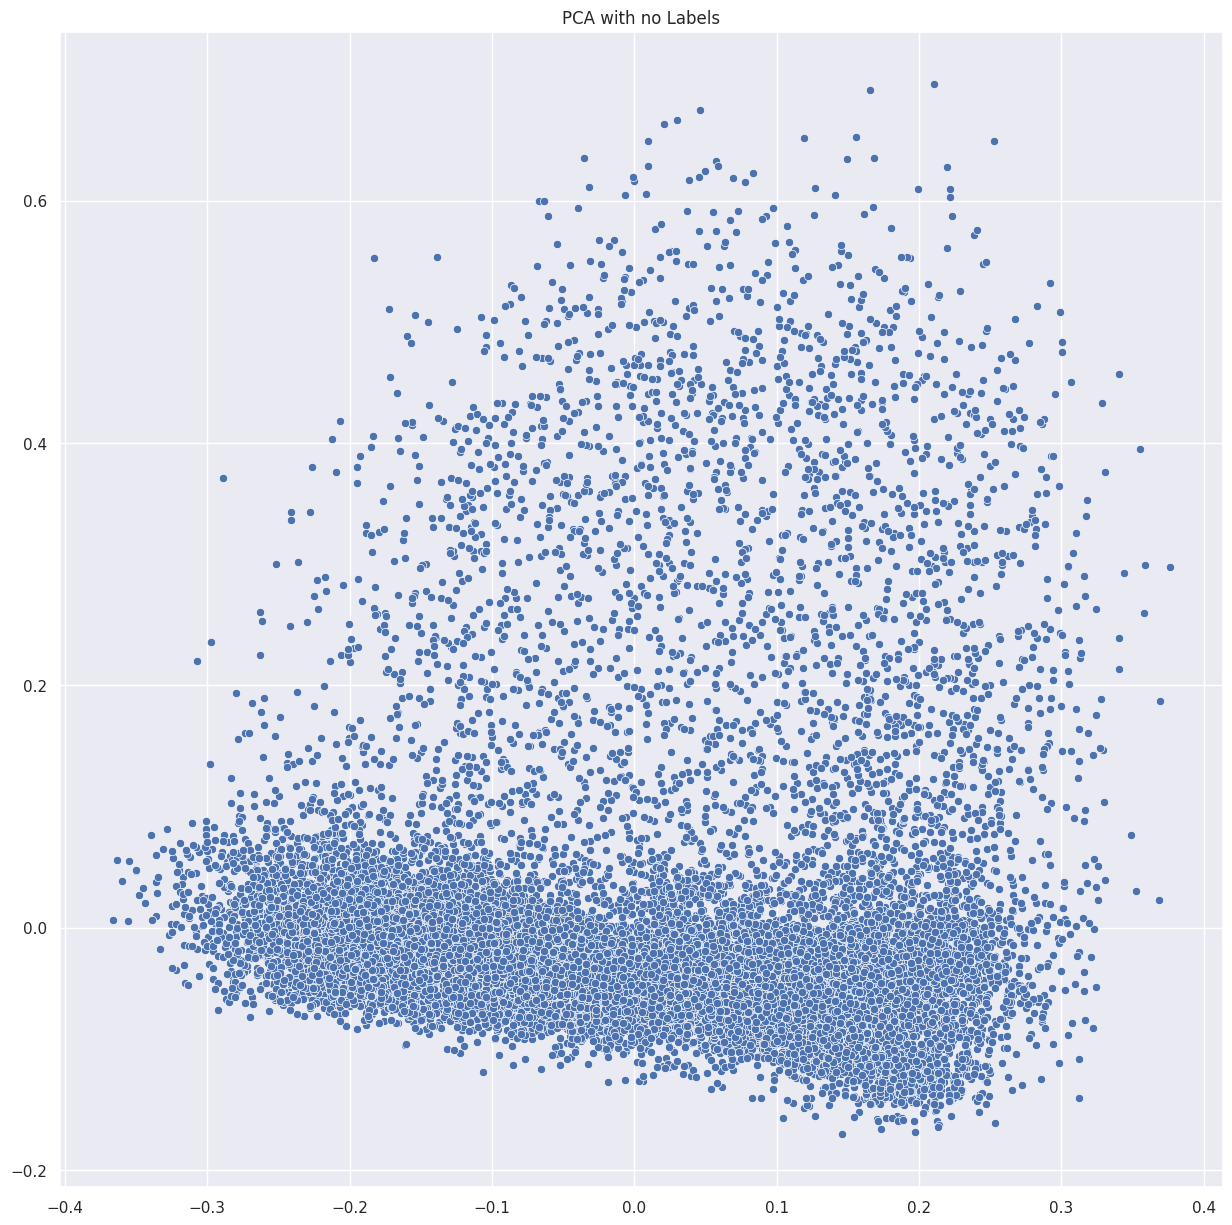

In [18]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=tfidf_reduced_pca[:,0], y=tfidf_reduced_pca[:,1], palette=palette)  # Specify x and y explicitly
plt.title('PCA with no Labels')
plt.savefig("/home/asma-rashidian/Documents/DrRahmani_projects/project3-DM-24-Dey-1402/results/tfidf_PCA_covid19.png")
plt.show()

### How many clusters? 

To find the best k value for k-means we'll look at the distortion at different k values. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters.

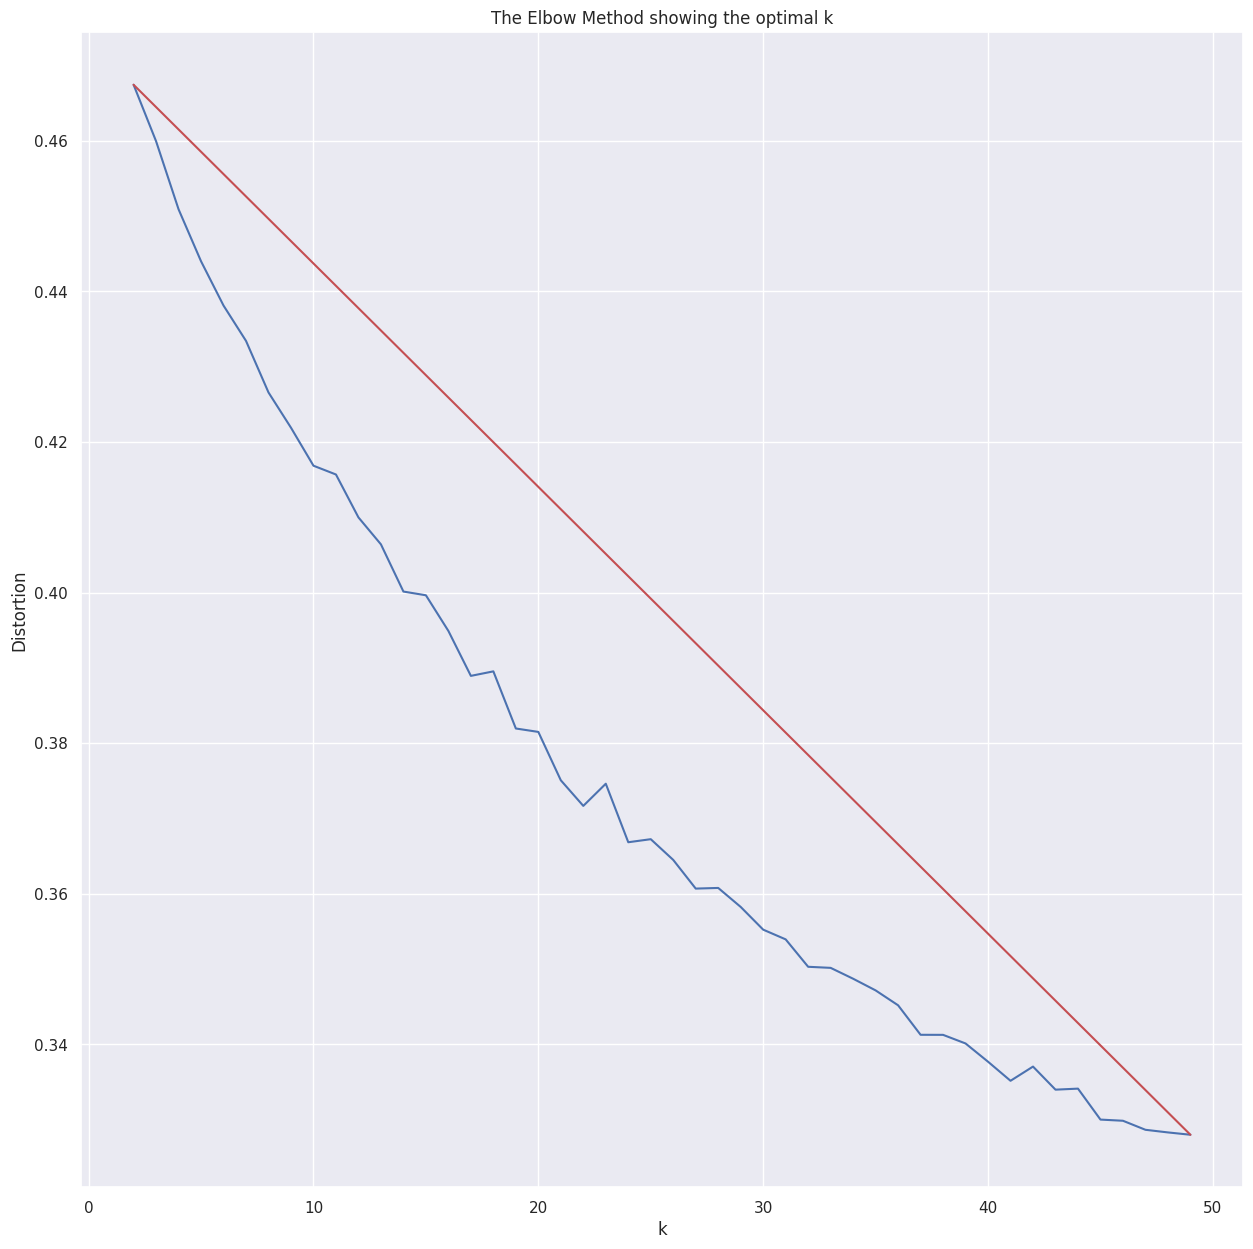

In [19]:

distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k).fit(tfidf_reduced_pca)
    k_means.fit(tfidf_reduced_pca)
    distortions.append(sum(np.min(cdist(tfidf_reduced_pca, k_means.cluster_centers_, 'euclidean'), axis=1)) / tfidf_result.shape[0])

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()



### Run k-means

Now that we have an appropriate k value, we can run k-means on the PCA-processed feature vector .

In [20]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
clusters_kmean= kmeans.fit(tfidf_reduced_pca)
print(clusters_kmean.labels_)
df['cluster_id_kmeans'] = clusters_kmean.labels_


[18 18 18 ... 18 18 14]


In [21]:
from sklearn.metrics import silhouette_score

# Assuming X contains your data and labels contains the cluster labels
silhouette_avg = silhouette_score(tfidf_reduced_pca, clusters_kmean.labels_ )
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.09841816881360502


### Dimensionality Reduction with t-SNE

Using [t-SNE](https://lvdmaaten.github.io/tsne) we can reduce our high dimensional features vector to 2 dimensions. By using the 2 dimensions as x,y coordinates, the body_text can be plotted. 

> t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space
> #### Cite: [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow: Second Edition | Aurélien Geron](https://github.com/ageron/handson-ml2)


In [5]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(tfidf_result)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 22787 samples in 0.024s...
[t-SNE] Computed neighbors for 22787 samples in 14.488s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22787
[t-SNE] Computed conditional probabilities for sample 2000 / 22787
[t-SNE] Computed conditional probabilities for sample 3000 / 22787
[t-SNE] Computed conditional probabilities for sample 4000 / 22787
[t-SNE] Computed conditional probabilities for sample 5000 / 22787
[t-SNE] Computed conditional probabilities for sample 6000 / 22787
[t-SNE] Computed conditional probabilities for sample 7000 / 22787
[t-SNE] Computed conditional probabilities for sample 8000 / 22787
[t-SNE] Computed conditional probabilities for sample 9000 / 22787
[t-SNE] Computed conditional probabilities for sample 10000 / 22787
[t-SNE] Computed conditional probabilities for sample 11000 / 22787
[t-SNE] Computed conditional probabilities for sample 12000 / 22787
[t-SNE] Computed conditional probabilities for s

/tmp/ipykernel_14646/3914928792.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], palette=palette)  # Specify x and y explicitly


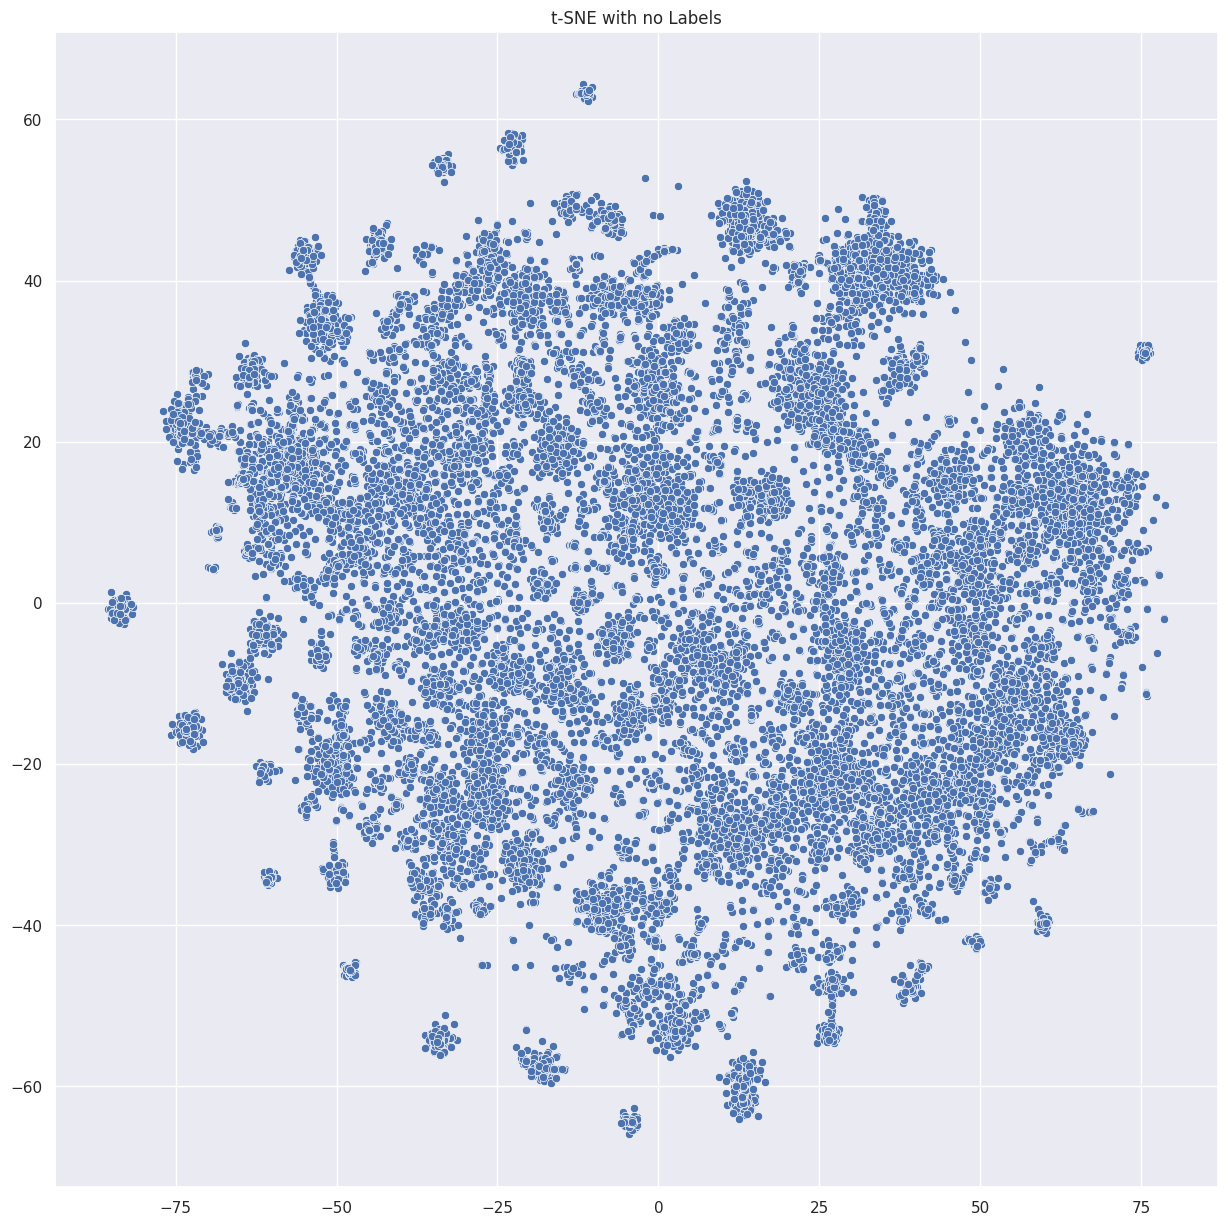

In [10]:

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], palette=palette)  # Specify x and y explicitly
plt.title('t-SNE with no Labels')
plt.savefig("/home/asma-rashidian/Documents/DrRahmani_projects/project3-DM-24-Dey-1402/results/tfidf_TSNE_covid19.png")
plt.show()

## Kmeans

In [11]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
clusters_kmean= kmeans.fit(X_embedded)
print(clusters_kmean.labels_)
y_pred = clusters_kmean.labels_

[15 15 15 ... 15 15 17]


In [12]:
from sklearn.metrics import silhouette_score

# Assuming X contains your data and labels contains the cluster labels
silhouette_avg = silhouette_score(X_embedded, y_pred )
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.3622532


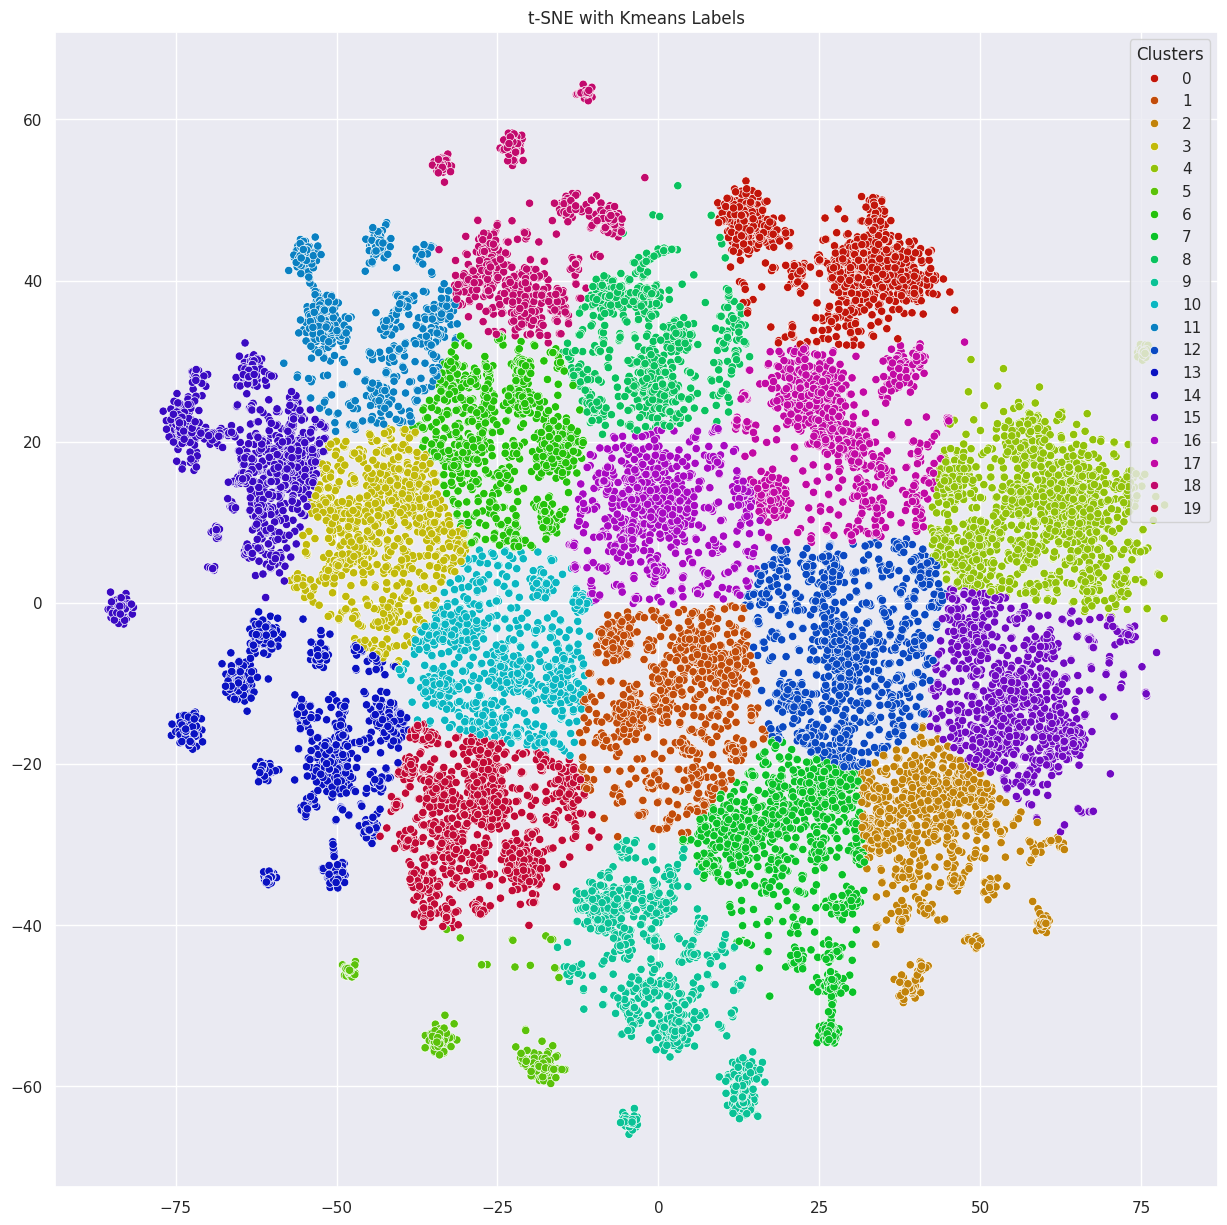

In [13]:
# sns settings
sns.set(rc={'figure.figsize':(15, 15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred, palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.legend(title='Clusters', loc='upper right')
plt.savefig("/home/asma-rashidian/Documents/DrRahmani_projects/project3-DM-24-Dey-1402/results/tfidf_TSNE_labeled_covid19.png")
plt.show()

## Hierarchical Clustering

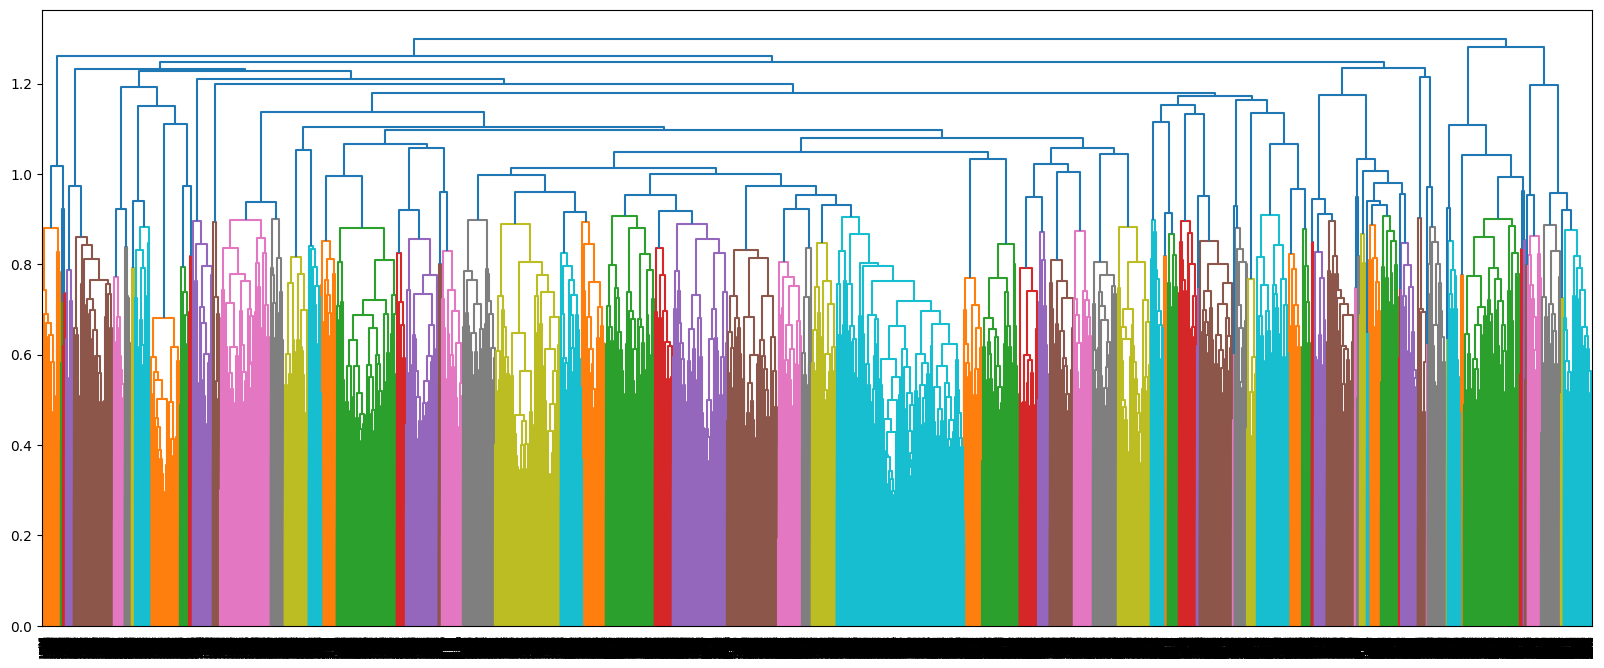

In [7]:
import scipy.cluster.hierarchy as sch 

plt.figure(figsize=(20,8))
dendrogram = sch.dendrogram(sch.linkage(tfidf_reduced_pca, method= 'complete'))


In [11]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score as sil 

metrics = ['euclidean']
linkages = ['complete' , 'single' , 'ward' , 'average']

for m in metrics:
    for l in linkages:
        hc=AgglomerativeClustering(n_clusters=2, metric=m, linkage=l)
        y_hc=hc.fit_predict(tfidf_reduced_pca)
        sil_score = sil(tfidf_reduced_pca, y_hc)
        print('For metric =',m,'and linkage =', l, 'Silhouette score is', np.round(sil_score,4))


For metric = euclidean and linkage = complete Silhouette score is 0.0691
For metric = euclidean and linkage = single Silhouette score is 0.2488
For metric = euclidean and linkage = ward Silhouette score is 0.0494
For metric = euclidean and linkage = average Silhouette score is 0.205


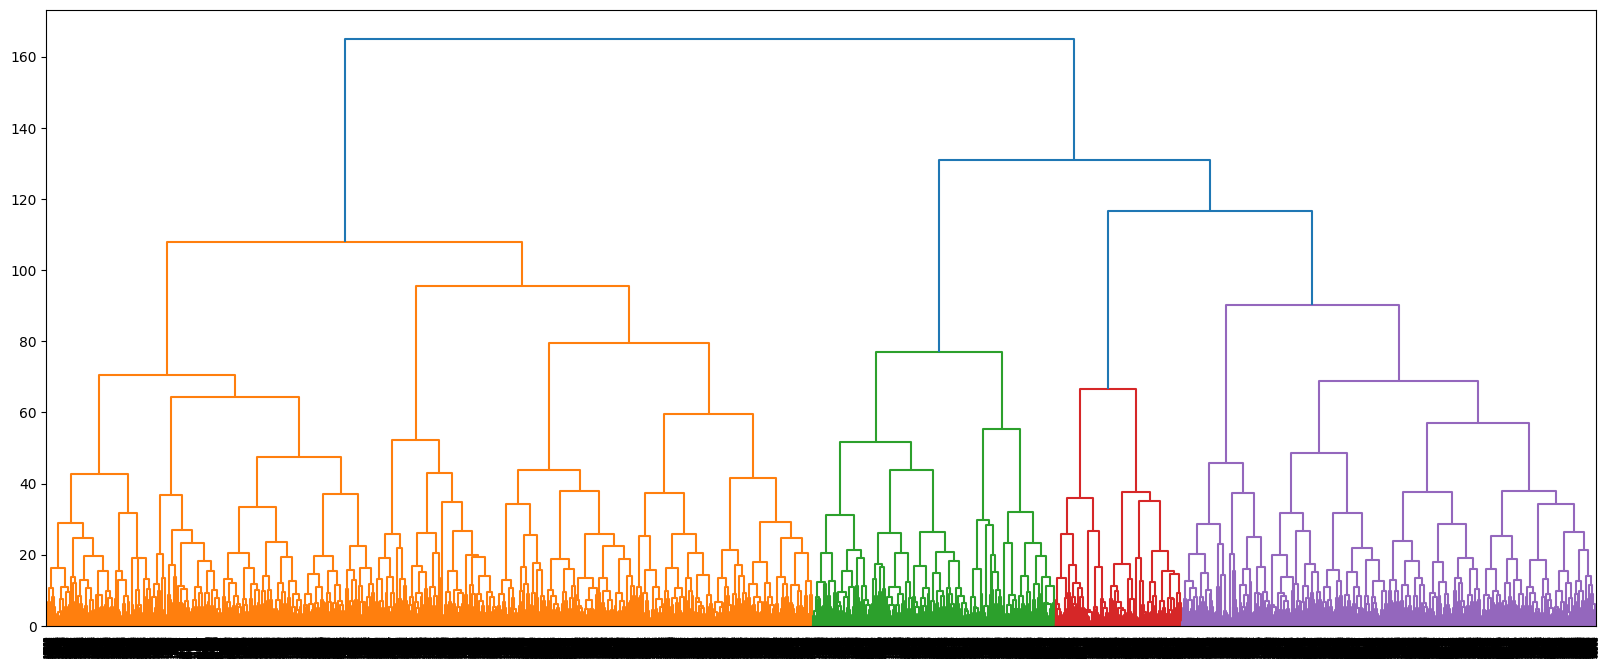

In [15]:
import scipy.cluster.hierarchy as sch 

plt.figure(figsize=(20,8))
dendrogram = sch.dendrogram(sch.linkage(X_embedded, method= 'complete'))


In [16]:
metrics = ['euclidean']
linkages = ['complete' , 'single' , 'ward' , 'average']

for m in metrics:
    for l in linkages:
        hc=AgglomerativeClustering(n_clusters=2, metric=m, linkage=l)
        y_hc=hc.fit_predict(X_embedded)
        sil_score = sil(X_embedded, y_hc)
        print('For metric =',m,'and linkage =', l, 'Silhouette score is', np.round(sil_score,4))


For metric = euclidean and linkage = complete Silhouette score is 0.3969
For metric = euclidean and linkage = single Silhouette score is 0.2515
For metric = euclidean and linkage = ward Silhouette score is 0.3544
For metric = euclidean and linkage = average Silhouette score is 0.3748


## Agglomerative Clustering

In [9]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

ac = AgglomerativeClustering(n_clusters=20)
clusters_agglo = ac.fit(tfidf_reduced_pca)
print(clusters_agglo.labels_)

[ 7  7  7 ... 12 12  5]


In [10]:
from sklearn.metrics import silhouette_score

# Assuming X contains your data and labels contains the cluster labels
silhouette_avg = silhouette_score(tfidf_reduced_pca, clusters_agglo.labels_ )
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.06906119502273925


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


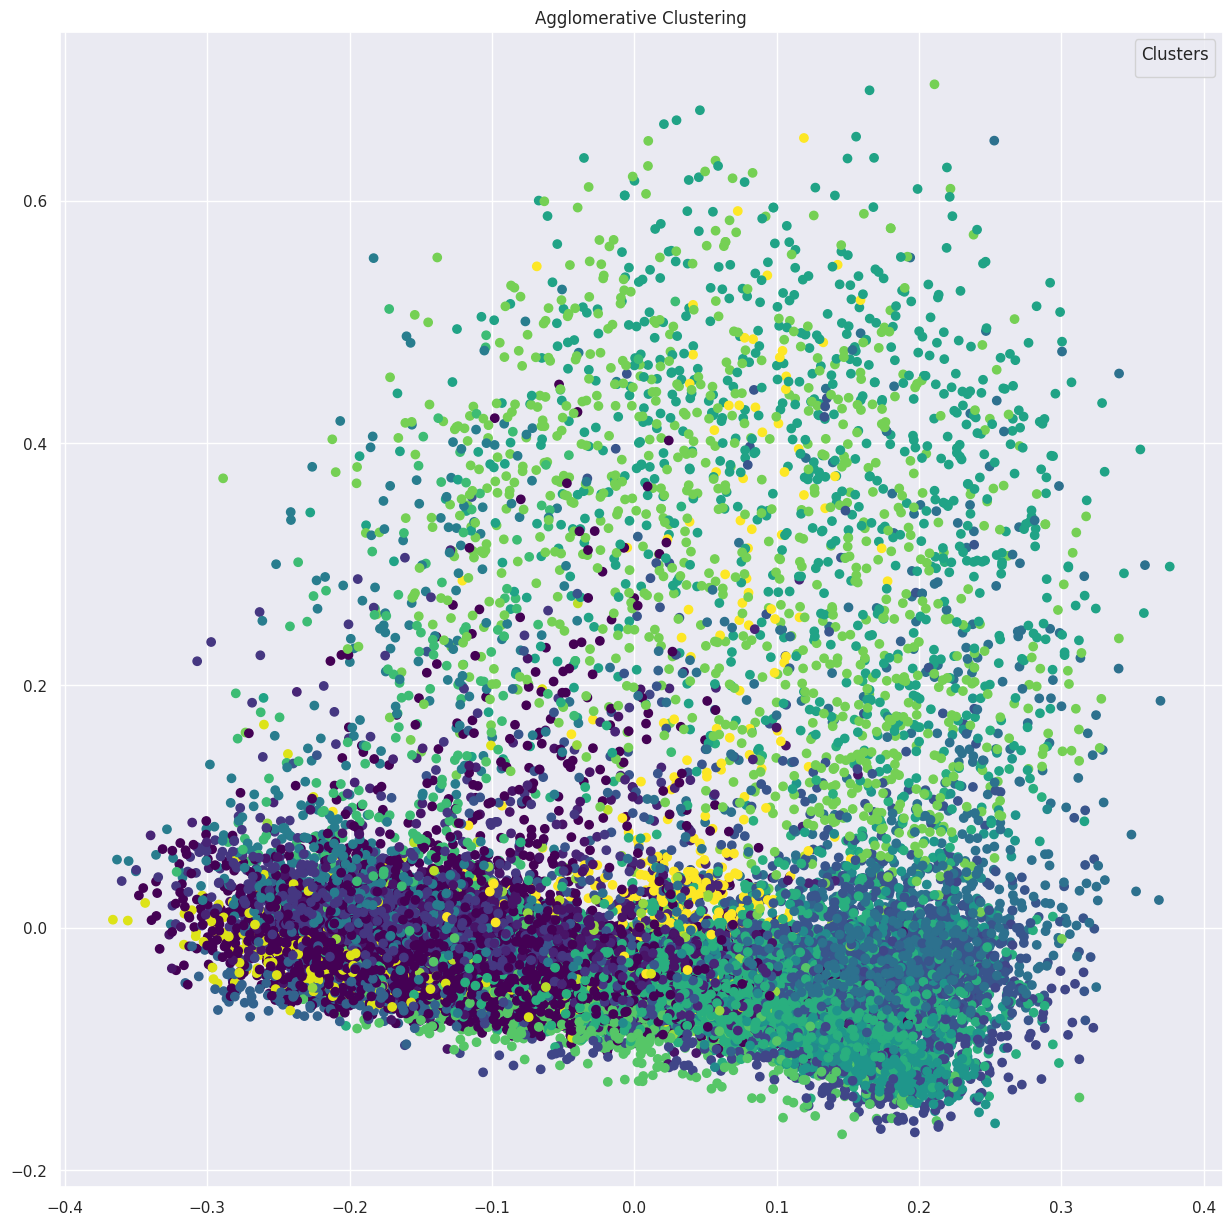

In [11]:
# sns settings
sns.set(rc={'figure.figsize':(15, 15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
plt.scatter(tfidf_reduced_pca[:, 0], tfidf_reduced_pca[:, 1], c=clusters_agglo.labels_, cmap='viridis')
plt.title("Agglomerative Clustering")
plt.legend(title='Clusters', loc='upper right')
plt.savefig("/home/asma-rashidian/Documents/DrRahmani_projects/project3-DM-24-Dey-1402/results/tfidf_pca_agglomerative_labeled_covid19.png")
plt.show()

In [6]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

ac = AgglomerativeClustering(n_clusters=20)
clusters_agglo = ac.fit(X_embedded)
print(clusters_agglo.labels_)

[8 9 8 ... 9 9 5]


In [7]:
from sklearn.metrics import silhouette_score

# Assuming X contains your data and labels contains the cluster labels
silhouette_avg = silhouette_score(X_embedded, clusters_agglo.labels_ )
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.32158846


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


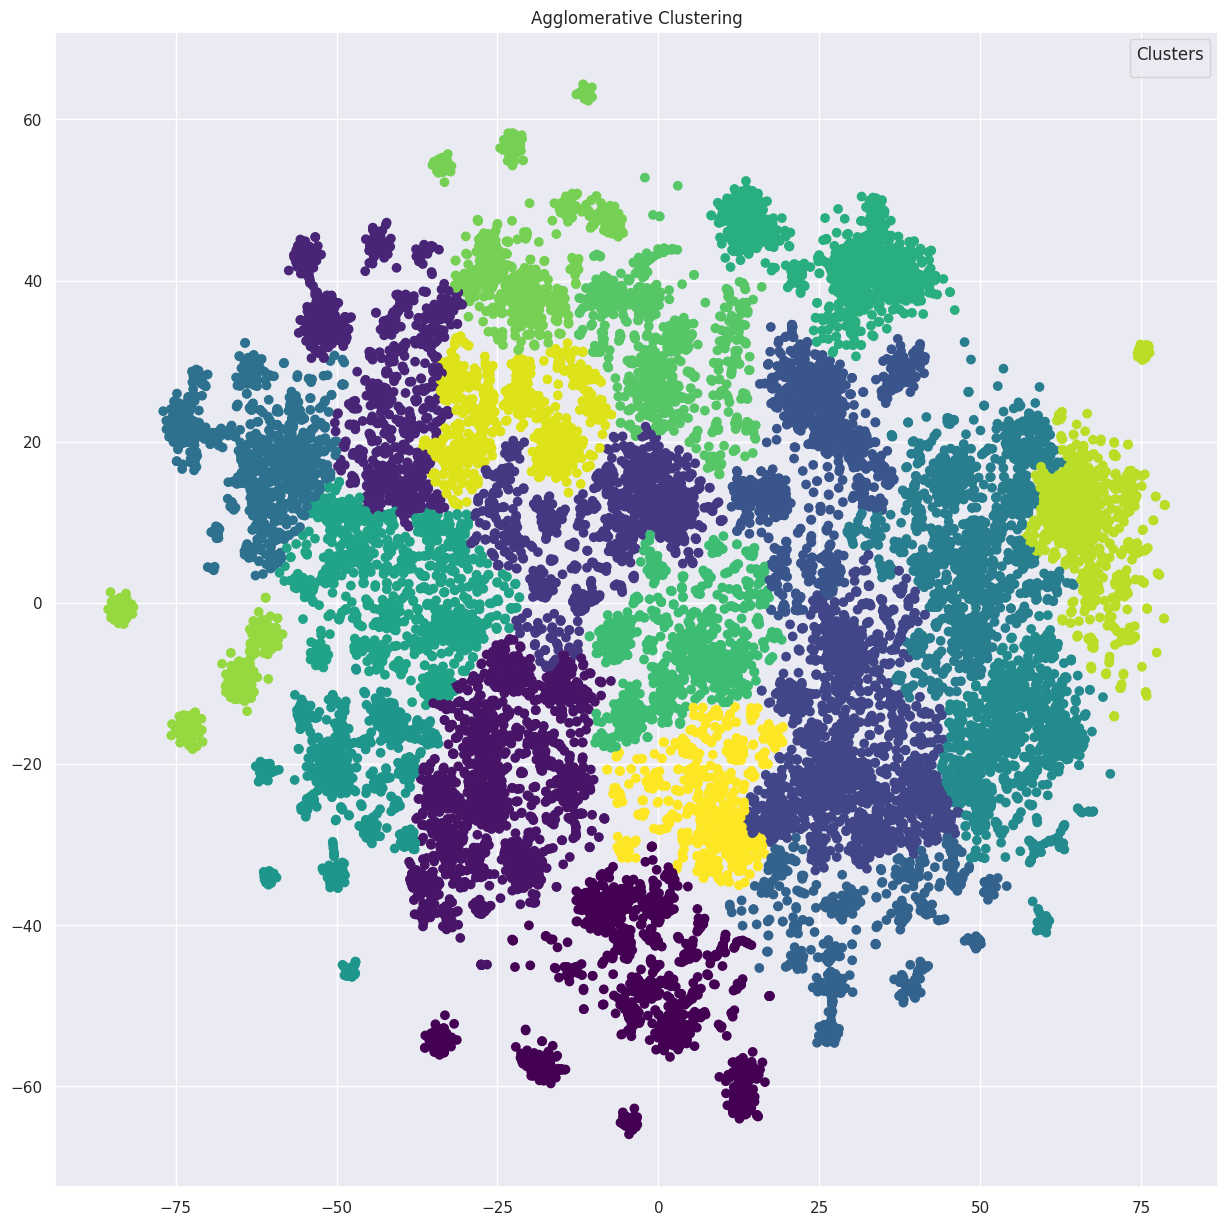

In [8]:
# sns settings
sns.set(rc={'figure.figsize':(15, 15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=clusters_agglo.labels_, cmap='viridis')
plt.title("Agglomerative Clustering")
plt.legend(title='Clusters', loc='upper right')
plt.savefig("/home/asma-rashidian/Documents/DrRahmani_projects/project3-DM-24-Dey-1402/results/tfidf_TSNE_agglomerative_labeled_covid19.png")
plt.show()

# Topic Modeling on Each Cluster

Now we will attempt to find the most significant words in each clusters. K-means clustered the articles but did not label the topics. Through topic modeling we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

For topic modeling, we will use `LDA (Latent Dirichlet Allocation)`. 

In [14]:
# First we will create 20 vectorizers, one for each of our cluster labels
vectorizers = []
    
for ii in range(0, 20):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))



In [15]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    cluster_data = df.loc[clusters_kmean.labels_ == current_cluster, 'combined_text']
    if len(cluster_data) > 0:
        try:
            vectorized_data.append(cvec.fit_transform(cluster_data))
        except Exception as e:
            print("Error vectorizing cluster {}: {}".format(current_cluster, e))
            vectorized_data.append(None)
    else:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [16]:
print(vectorized_data)

[<1106x2121 sparse matrix of type '<class 'numpy.int64'>'
	with 80900 stored elements in Compressed Sparse Row format>, <1231x2549 sparse matrix of type '<class 'numpy.int64'>'
	with 88915 stored elements in Compressed Sparse Row format>, <1104x2408 sparse matrix of type '<class 'numpy.int64'>'
	with 87000 stored elements in Compressed Sparse Row format>, <1155x2340 sparse matrix of type '<class 'numpy.int64'>'
	with 85600 stored elements in Compressed Sparse Row format>, <1753x2773 sparse matrix of type '<class 'numpy.int64'>'
	with 131044 stored elements in Compressed Sparse Row format>, <332x1155 sparse matrix of type '<class 'numpy.int64'>'
	with 22937 stored elements in Compressed Sparse Row format>, <1122x2350 sparse matrix of type '<class 'numpy.int64'>'
	with 82878 stored elements in Compressed Sparse Row format>, <1337x2395 sparse matrix of type '<class 'numpy.int64'>'
	with 99157 stored elements in Compressed Sparse Row format>, <927x2075 sparse matrix of type '<class 'numpy.

## LDA( Latent Dirichlet Allocation)

In [17]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42, verbose=False)

In [18]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

In [19]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [20]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [21]:
all_keywords[2][:10]

['pneumonia',
 'infect',
 'sever',
 'covid',
 'studi',
 'review',
 'clinic',
 'aerosol',
 'air',
 'group']

In [22]:
len(all_keywords)

20

In [23]:
f=open('/home/asma-rashidian/Documents/DrRahmani_projects/project3-DM-24-Dey-1402/proceed_data/vectorizing_results/topics_tfidf.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [24]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

In [25]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(tfidf_result, y_pred, test_size=0.2)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 18229
X_test size: 4558 



In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=-1)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=-1)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  82.089 %
     Precision:  82.235 %
        Recall:  81.975 %
      F1 score:  82.017 %
